In [3]:
%matplotlib inline

In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack

$\newcommand{\R}{\mathbb R} \newcommand{\N}{\mathbb N}$On s'intéresse au cas d'un faisceau lumineux traversant un trou rectangulaire de dimensions $a,b$ avec $b\gg a$. On sait qu'il subit un phénomène de diffraction.

On cherchera les modes transverses $\mathbf E = E(x,z)e^{-i\omega t}\mathbf e_x$. L'équation aux dérivées partielles vérifiée par $E$ est
$$
\frac{\partial^2E}{\partial x^2} + \frac{\partial^2E}{\partial z^2} +k^2E = 0,\quad k =\frac\omega c
$$
On cherche une solution progressive harmonique avec une enveloppe
$$
E(x,z) = u(x,z)e^{ikz}
$$

Alors
$$
\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial z^2} + 2ik\frac{\partial u}{\partial z} = 0
$$
soit $$
\frac{\partial^2u}{\partial x^2} + 2ik\frac{\partial u}{\partial z}=0
$$
en négligeant la dérivée seconde par rapport à $z$.
La transformée de Fourier $\hat u$ de $u$ par rapport à $x$ vérifie donc l'équation d'ordre 1
$$
-k_x^2\hat u + 2ik\frac{\partial \hat u}{\partial z} = 0.
$$

D'où $\hat u(k_x,z) = \hat u(k_x,0)\exp\left(\frac{2ikz}{k_x^2}\right)$.

Ainsi \\[u(x,z) = \int_\mathbb{R} \hat u(k_x,0)\exp\left(\frac{2ikz}{k_x^2}\right)e^{ik_xx}\,\mathrm dk_x.\\]

In [386]:
class Diffract:
    x,z,kx = sp.symbols("x z kx", real=True)
    t, omega, c0 = sp.symbols("t omega c", real=True)
    
    def __init__(self):
        k = self.omega/self.c0
        x,z,kx = self.x,self.z,self.kx
        self.phasor = sp.exp(2*sp.I*k*z/kx**2)*sp.exp(sp.I*kx*x)
    
    def bake_env(self, freqs, amps):
        
        # L'enveloppe est la série de Fourier (intégrale approchée)
        # des phaseurs
        phasor = self.phasor
        amps = amps[freqs != 0]
        freqs = freqs[freqs != 0]
        N = len(amps)
        env = sum(amps[i]*phasor.subs({self.kx:freqs[i]}) for i in range(N))
        self.enveloppe = env
        x, z = self.x, self.z
        t,omega = self.t,self.omega
        k = omega/self.c0
        expr = self.enveloppe*sp.exp(sp.I*(k*z - omega*t))
        cel = 3e8
        self.expression = expr.subs({self.c0:cel})
        fonc = sp.lambdify((x,z,t,omega),sp.re(self.expression),"numpy")
        self.func = fonc
    
    def graphe(self, xm, zm, t, puls):
        fonc = self.func
        grid = np.mgrid[-xm:xm:100j, 0:zm:100j]
        xg, yg = grid
        
        
        fig = plt.figure(0, figsize=(8,8))
        cmap = 'inferno'
        extent = [-xm,xm,0,zm]
        if not(hasattr(t,"__iter__")):
            t = [t]
        if not(hasattr(puls,"__iter__")):
            puls = [puls]
        p = len(t)
        m = len(puls)
        
        for j,omi in enumerate(puls):
            for i,ti in enumerate(t):
                i += 1
                vals = fonc(xg, yg, ti, omi)**2
                ax = fig.add_subplot(m,p,i+p*j)

                col = ax.imshow(vals, 
                        aspect='auto',
                        extent=extent,cmap=cmap,
                        interpolation="lanczos")
                ax.set_xlabel(r"Abscisse $x$ (m)")
                ax.set_ylabel(r"Distance $z$ (m)")
                ax.set_title(r"Temps: $t={:.3e}$ s".format(ti)+ \
                            "\nFréquence: " +\
                             r"$\omega = {:.3e}$ Hz".format(omi))
        fig.tight_layout()
        fig.suptitle("Intensité de l'onde diffractée")
        fig.subplots_adjust(top=0.85)

# Profil gaussien

In [388]:
difr = Diffract()

In [389]:
def gauss(x):
    return np.exp(-x**2/(2*1e0**2))

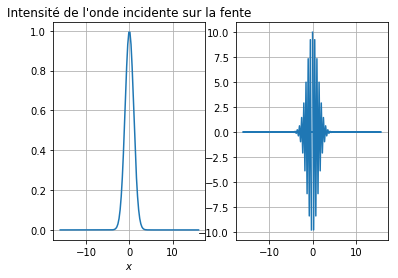

In [394]:
Ns = 128
fs = 8
xm = Ns/fs
Xar = np.linspace(-xm,xm,Ns)
profilX = gauss(Xar)

fig = plt.figure(1)
ax0 = fig.add_subplot(121)
ax0.grid(True)
ax0.plot(Xar, profilX)
ax0.set_xlabel("$x$")
ax0.set_title("Intensité de l'onde incidente sur la fente")

profil = fftpack.fft(profilX)
freqs = fftpack.fftfreq(Ns, dt)
ax1 = fig.add_subplot(122)
ax1.grid(True)
ax1.plot(freqs, profil.real)

In [395]:
difr.bake_env(freqs, profil)

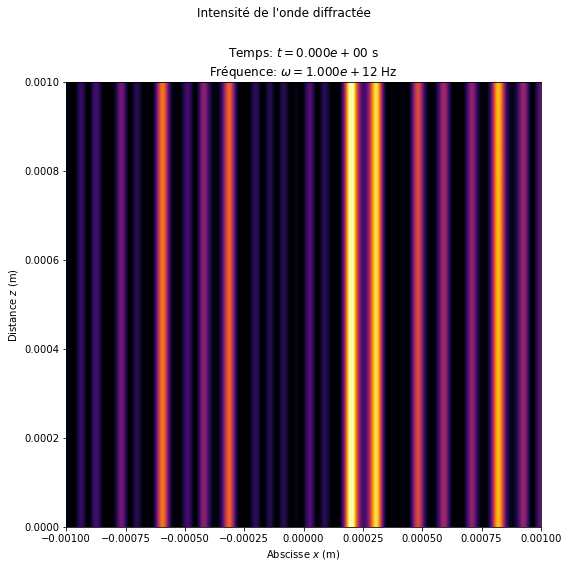

In [398]:
difr.graphe(0.001,0.001,0,1e12)